## 에피소드별 마지막 행동 패턴 분석

In [ ]:
df_copy.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,...,0.000000,3,1,52.584313,0.009786,0.009785,0.999952,36.085464,0,0.011117
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,...,-0.975361,2,1,73.101872,-0.056127,-0.056097,0.998425,56.635419,1,0.061117
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,...,0.582957,2,1,67.712480,0.049746,0.049725,0.998763,51.239461,2,0.082800
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,...,0.167104,2,1,67.266604,0.140004,0.139547,0.990215,50.980073,3,0.136667
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,...,-0.201285,2,0,75.762127,0.377727,0.368809,0.929505,60.730940,4,0.193883


In [ ]:
df_copy[['end_x', 'end_y']].isnull().sum()

end_x    2414
end_y    2414
dtype: int64

In [ ]:
# 각 에피소드별 마지막 행동
last_events = (
    df_copy
    .sort_values(["game_episode", "time_seconds"])
    .groupby("game_episode")
    .tail(1)
)

print(last_events["action_type"].value_counts())
print("\n")
print(last_events[["action_type", "result_name"]].value_counts())

Pass     17848
Carry        1
Name: action_type, dtype: int64


action_type  result_name 
Pass         Successful      9950
             Unsuccessful    7898
dtype: int64


In [ ]:
last_events[(last_events['action_type'] == 'Carry')]

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,action_type,result_name,start_x,...,move_angle_cos,x_zone,y_lane,dist_to_opp_goal,angle_to_opp_goal,angle_to_opp_goal_sin,angle_to_opp_goal_cos,dist_to_opp_box_center,episode_event_index,match_minutes
305444,126451,1,18,1307.001,2354,500145,593,Carry,NaN,48.84936,...,1.0,3,2,65.292006,-0.535541,-0.510307,0.859993,51.791167,11,21.78335


In [ ]:
last_events.groupby("action_type")["end_x"].agg(["mean", "std", "min", "max", "count"]).sort_values("std", ascending=False)

,mean,std,min,max,count
action_type,,,,,
Pass,68.453262,23.853676,0.000000,105.000000,15434
Carry,61.276635,NaN,61.276635,61.276635,1


In [ ]:
last_events.groupby("action_type")["end_y"].agg(["mean", "std", "min", "max", "count"]).sort_values("std", ascending=False)

,mean,std,min,max,count
action_type,,,,,
Pass,33.614992,24.34604,0.000000,68.000000,15434
Carry,57.771644,NaN,57.771644,57.771644,1


In [ ]:
last_events["is_sideline_end"] = (
    (last_events["end_x"] < 5) |
    (last_events["end_x"] > 100)
)

last_events["is_sideline_end"].mean()

0.047229536668720935

In [ ]:
last_events["is_sideline_end"] = (
    (last_events["end_y"] < 5) |
    (last_events["end_y"] > 63)
)

last_events["is_sideline_end"].mean()

0.30365846826152726

In [ ]:
# 1) 시간 순 정렬
df_sorted = df.sort_values(
    ["game_episode", "time_seconds", "action_id"]
).copy()

# 2) 에피소드별 마지막 이벤트
last_events = (
    df_sorted
    .groupby("game_episode", as_index=False)
    .tail(1)
    .reset_index(drop=True)
)

last_train = last_events[last_events["is_train"] == 1].copy()

last_train["dx"] = last_train["end_x"] - last_train["start_x"]
last_train["dy"] = last_train["end_y"] - last_train["start_y"]

In [ ]:
X_cluster = last_train[["dx", "dy"]].copy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

last_train["pass_cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = (
    last_train
    .groupby("pass_cluster")[["dx", "dy"]]
    .mean()
)

print(cluster_summary)

last_train["is_sideline_end"] = (
    (last_train["end_y"] < 5) |
    (last_train["end_y"] > 63)
)

print(last_train.groupby("pass_cluster")["is_sideline_end"].mean())


                     dx         dy
pass_cluster                      
0              4.449123   0.470468
1             18.746551 -21.530430
2             21.961067  24.100739
3             41.377084  -1.680399
pass_cluster
0    0.335406
1    0.401479
2    0.430624
3    0.283590
Name: is_sideline_end, dtype: float64


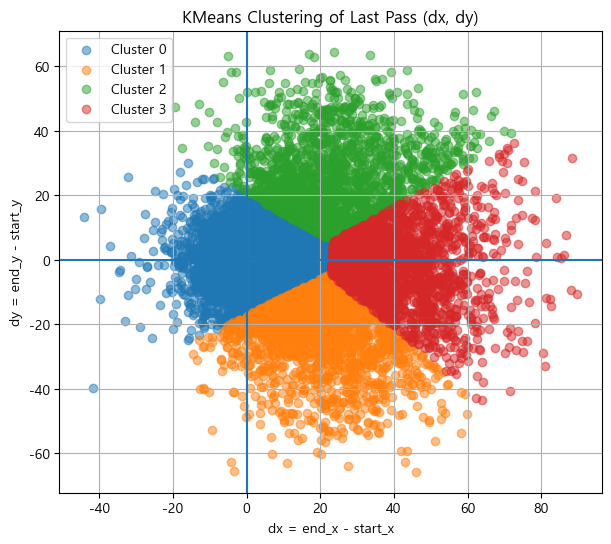

In [ ]:
plt.figure(figsize=(7, 6))

for c in sorted(last_train["pass_cluster"].unique()):
    subset = last_train[last_train["pass_cluster"] == c]
    plt.scatter(
        subset["dx"],
        subset["dy"],
        alpha=0.5,
        label=f"Cluster {c}"
    )

# scatter plot
plt.axhline(0)
plt.axvline(0)
plt.xlabel("dx = end_x - start_x")
plt.ylabel("dy = end_y - start_y")
plt.title("KMeans Clustering of Last Pass (dx, dy)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_copy.columns

Index(['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id',
       'player_id', 'action_id', 'action_type', 'result_name', 'start_x',
       'start_y', 'end_x', 'end_y', 'is_home', 'game_episode', 'is_train',
       'game_day', 'game_date', 'home_score', 'away_score', 'venue',
       'home_team_name_ko', 'away_team_name_ko', 'player_role_pass',
       'player_role_label', 'prev1_end_x', 'prev1_end_y', 'prev1_action_type',
       'prev1_result_name', 'prev2_end_x', 'prev2_end_y', 'prev2_action_type',
       'prev2_result_name', 'prev3_end_x', 'prev3_end_y', 'prev3_action_type',
       'prev3_result_name', 'seq2_action', 'dx', 'dy', 'seq2_action_top',
       'prev_start_x', 'prev_start_y', 'legal_speed', 'move_angle',
       'move_angle_sin', 'move_angle_cos', 'x_zone', 'y_lane',
       'dist_to_opp_goal', 'angle_to_opp_goal', 'angle_to_opp_goal_sin',
       'angle_to_opp_goal_cos', 'dist_to_opp_box_center',
       'episode_event_index', 'match_minutes'],
      dtype='object'

In [ ]:
# 기본값
df_copy["pass_cluster"] = -1

# 클러스터 적용 가능한 row 조건
mask = (
    df_copy["dx"].notna() &
    df_copy["dy"].notna() &
    df_copy["action_type"].str.contains("Pass", na=False)
)

# transform + predict
X_all = df_copy.loc[mask, ["dx", "dy"]].values
X_all_scaled = scaler.transform(X_all)

df_copy.loc[mask, "pass_cluster"] = kmeans.predict(X_all_scaled)

In [ ]:
df_copy['pass_cluster'].value_counts()

-1    201906
 0    151591
 1     26735
 2     20498
 3      9101
Name: pass_cluster, dtype: int64

In [ ]:
is_pass = df_copy["action_type"].astype(str).str.contains("Pass", na=False)

n_pass_total = is_pass.sum()
n_pass_minus1 = ((df_copy["pass_cluster"] == -1) & is_pass).sum()

print("패스 전체:", n_pass_total)
print("패스인데 -1:", n_pass_minus1)
print("패스인데 -1 비율:", n_pass_minus1 / max(n_pass_total, 1))

패스 전체: 210339
패스인데 -1: 2414
패스인데 -1 비율: 0.011476711403971683


## 각 에피소드의 마지막 행동 분석  

1. 마지막 액션은 모두 Pass + 드리블 한개(이상치)  
2. pass의 성공률은 60% -> 설명력이 낮음
3. 마지막 행동은 Pass 이므로, 거리에 대한 클러스터링 계산 수행시에 모델이 잘 예측할 것이다  
4. 클러스터 4개의 클러스터 결과 다음과 같이 나왔음

## 직전의 이동 수치량 반영 피처

가설: 모든 에피소드에서의 마지막 액션은 PASS 즉, 이전에 어떤 상황이였냐를 수치적으로 표현하면 모델의 해석력이 올라갈 것이다.

Q: 왜 해당 피처를 추가했는가?
A: 이전 액션을 수치적으로 설명하기 위함

해당 액션에 대한 수치적인 표현 뿐만 아니라, 이전과의 연결성을 위한 수치 표현성을 높이고 벡터를 이용하여 공의 정확한 이동 궤적을 모델이 해석할 수 있게 함


In [ ]:
df_copy["prev1_dx"] = df_copy["prev1_end_x"] - df_copy["start_x"]
df_copy["prev1_dy"] = df_copy["prev1_end_y"] - df_copy["start_y"]
df_copy["prev1_dist"] = np.sqrt(df_copy["prev1_dx"]**2 + df_copy["prev1_dy"]**2)

theta = np.arctan2(df_copy["prev1_dy"], df_copy["prev1_dx"])
df_copy["prev1_angle_sin"] = np.sin(theta)
df_copy["prev1_angle_cos"] = np.cos(theta)

#wing vs center 사후분석
모델 학습 결과, 중앙 구간은 비교적 안정적인 예측 성능을 보인 반면,
측면 구간에서는 예측 오차가 불안정하게 나타남



데이터 분포 및 난이도 분석 수행

In [ ]:
#측면 샘플 수가 적은가?
df_copy["is_wing"].value_counts(normalize=True)

,proportion
is_wing,
False,0.702253
True,0.297747


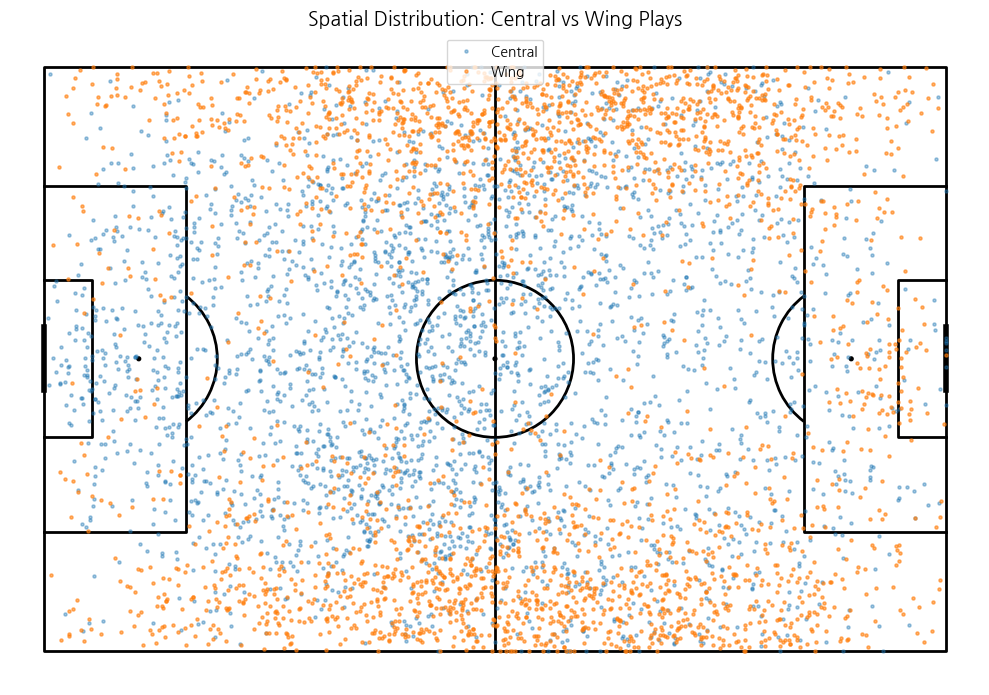

In [ ]:
# pitch 생성
pitch = Pitch(
    pitch_type='custom',
    pitch_length=105,
    pitch_width=68,
    line_color='black',
    pitch_color='white'
)
fig, ax = pitch.draw(figsize=(10, 7))

# 중앙 / 측면 분리
central = df_copy[~df_copy["is_wing"]]
wing = df_copy[df_copy["is_wing"]]

# 샘플링해서 겹침 완화
central_s = central.sample(3000, random_state=42)
wing_s = wing.sample(3000, random_state=42)

# 중앙 플레이
pitch.scatter(
    central_s["end_x"], central_s["end_y"],
    ax=ax, s=5, alpha=0.4, label="Central"
)

# 측면 플레이
pitch.scatter(
    wing_s["end_x"], wing_s["end_y"],
    ax=ax, s=5, alpha=0.6, label="Wing"
)

ax.legend(loc="upper center")
ax.set_title("Spatial Distribution: Central vs Wing Plays", fontsize=14)
plt.show()


In [ ]:
df_copy.groupby("is_wing")["end_y"].describe()

,count,mean,std,min,25%,50%,75%,max
is_wing,,,,,,,,
False,286299.0,34.115386,16.640261,0.0,21.052766,34.205292,47.226646,68.0
True,121118.0,34.205417,25.453616,0.0,7.930976,35.159196,60.181258,68.0


<Axes: title={'center': 'err_y'}, xlabel='is_wing'>

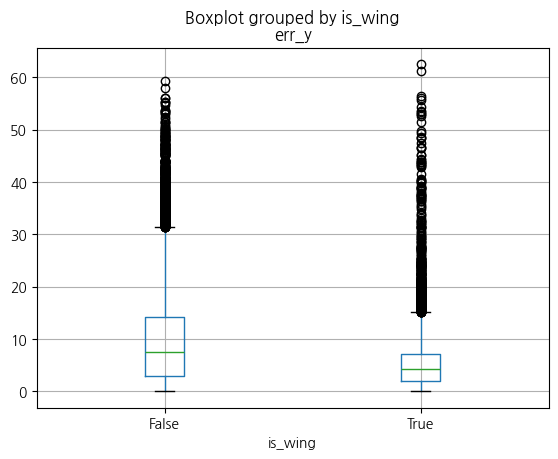

In [ ]:
df_err.boxplot(column="err_y", by="is_wing")

#분석 결과

데이터 분포가 중앙 구간에 편중되어 있다.

평균 난이도 측면에서 중앙과 측면 구간이 유사하여 측면 구간이 더 예측이 어려운 영역이라고 보기는 어렵다.

그러나, 분산 및 분위수 분석 결과, 터치라인, 공간 부족, 급격한 방향전환 등의 특수한 플레이가 발생하여
소수의 샘플에서 극단적으로 큰 예측 오차가 발생한다.

특히 IQR 기준, 중앙 구간은 26이고 측면 구간은 52로 2배 이상 넓어 측면 구간의 데이터가 불균일함

이러한 극단 오차가 성능 저하의 원인이다.

-> 모델이 측면 구간을 명확히 인식할 수 있도록 측면 전용 피처를 사용하여 실험 진행


In [ ]:
#is_wing은 사용 X
df_copy["is_wing"] = (df_copy["start_y"] < 10) | (df_copy["start_y"] > 58)
df_copy["wing_prev_dy"] = df_copy["prev1_dy"] * df_copy["is_wing"]
df_copy["wing_prev_angle_sin"] = df_copy["prev1_angle_sin"] * df_copy["is_wing"]
df_copy["wing_prev_angle_cos"] = df_copy["prev1_angle_cos"] * df_copy["is_wing"]